<a href="https://colab.research.google.com/github/ParthN9i4/ML-using-TenSEAL/blob/main/Enc_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tenseal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 27.8 MB/s eta 0:00:00


In [ ]:
!pip install memory_profiler

In [ ]:
import tenseal as ts

context = ts.context(ts.SCHEME_TYPE.CKKS, poly_modulus_degree = 4096, plain_modulus = 1032193)
print(context)

In [ ]:
import torch
import cProfile
import memory_profiler
import tenseal as ts
import pandas as pd
import random

from time import perf_counter
from time import time

# those are optional and are not necessary for training
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Set random seeds to initialize the model weight of the model
torch.random.manual_seed(73)
random.seed(73)

def split_train_test(x, y, test_ratio=0.3, random_state=73):
    # And test set
    idxs = [i for i in range(len(x))]
    random.seed(random_state)  # Set the random seed
    random.shuffle(idxs)
    # Delimiter between test and train data
    delim = int(len(x) * test_ratio)
    test_idxs, train_idxs = idxs[:delim], idxs[delim:]
    #convert y to a tensor
    return x[train_idxs], y[train_idxs], x[test_idxs], y[test_idxs]

# Assuming 'Class' is the column representing the target variable
# Replace 'Class' with the actual name of your target variable if different
target_column = 'TenYearCHD'

# Load your DataFrame 'data'
data = pd.read_csv("framingham.csv")  # Replace with your dataset path

# Display class distribution
class_distribution = data[target_column].value_counts()

# Find minority and majority classes
minority_class = class_distribution.idxmin()
majority_class = class_distribution.idxmax()

# Print class distribution and identified minority/majority classes
print("Class distribution:")
print(class_distribution)

print("\nMinority class:", minority_class)
print("Majority class:", majority_class)


Class distribution:
0    3594
1     644
Name: TenYearCHD, dtype: int64

Minority class: 1
Majority class: 0


In [ ]:
from imblearn.over_sampling import SMOTE

# Assuming 'Class' is the column representing the target variable
# Replace 'Class' with the actual name of your target variable if different
target_column = 'TenYearCHD'

# Load your DataFrame 'data'
data = pd.read_csv("framingham.csv")

# drop rows with missing values
data = data.dropna()
# drop some features
data = data.drop(columns=["education", "currentSmoker", "BPMeds", "diabetes", "diaBP", "BMI"])

# Display class distribution before oversampling
print("Class distribution before oversampling:")
print(data[target_column].value_counts())

# Separate features (X) and target variable (y)
X = data.drop(target_column, axis=1)
y = data[target_column]

# Initialize SMOTE with desired sampling strategy
# In this case, 'minority' indicates that we want to oversample the minority class
smote = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE to the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Concatenate the resampled data to create the oversampled DataFrame
oversampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name=target_column)], axis=1)

# Display class distribution after oversampling
print("\nClass distribution after oversampling:")
print(oversampled_data[target_column].value_counts())

# Triple the size by repeating the process
oversampled_data_tripled = oversampled_data.copy()
for _ in range(2):
    X_resampled, y_resampled = smote.fit_resample(oversampled_data.drop(target_column, axis=1), oversampled_data[target_column])
    oversampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name=target_column)], axis=1)
    oversampled_data_tripled = pd.concat([oversampled_data_tripled, oversampled_data], ignore_index=True)

# Display class distribution after tripling the size
print("\nClass distribution after tripling the size:")
print(oversampled_data_tripled[target_column].value_counts())


Class distribution before oversampling:
0    3099
1     557
Name: TenYearCHD, dtype: int64

Class distribution after oversampling:
0    3099
1    3099
Name: TenYearCHD, dtype: int64

Class distribution after tripling the size:
0    9297
1    9297
Name: TenYearCHD, dtype: int64


In [ ]:
#oversampled_data_tripled['Class'].value_counts()
df = oversampled_data_tripled
print(df['TenYearCHD'].value_counts())
df.head()

0    9297
1    9297
Name: TenYearCHD, dtype: int64


,male,age,cigsPerDay,prevalentStroke,prevalentHyp,totChol,sysBP,heartRate,glucose,TenYearCHD
0,1,39,0.0,0,0,195.0,106.0,80.0,77.0,0
1,0,46,0.0,0,0,250.0,121.0,95.0,76.0,0
2,1,48,20.0,0,0,245.0,127.5,75.0,70.0,0
3,0,61,30.0,0,1,225.0,150.0,65.0,103.0,1
4,0,46,23.0,0,0,285.0,130.0,85.0,85.0,0


In [ ]:
%load_ext memory_profiler

def heart_disease_data():
    global data
    # balance data
    grouped = data.groupby('TenYearCHD')
    data = grouped.apply(lambda x: x.sample(grouped.size().min(), random_state=73).reset_index(drop=True))
    print(data.head())
    # extract labels
    y = torch.tensor(data["TenYearCHD"].values).float().unsqueeze(1)
    data = data.drop("TenYearCHD", 'columns')
    # standardize data
    data = (data - data.mean()) / data.std()
    x = torch.tensor(data.values).float()
    print(data.head())
    return split_train_test(x, y)

x_train, y_train, x_test, y_test = heart_disease_data()

featuresTrain = x_train
targetsTrain = y_train
featuresTest = x_test
targetsTest = y_test

print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")
#cProfile.run('heart_disease_data()')
#%memit heart_disease_data()
!cat /proc/cpuinfo
!cat /proc/meminfo

              male  age  cigsPerDay  prevalentStroke  prevalentHyp  totChol  \
TenYearCHD                                                                    
0          0     1   35        20.0                0             0    223.0   
           1     1   43         0.0                0             0    200.0   
           2     1   46         0.0                0             1    185.0   
           3     0   63         0.0                0             1    281.0   
           4     0   59         0.0                0             0    292.0   

              sysBP  heartRate  glucose  TenYearCHD  
TenYearCHD                                           
0          0  128.0       80.0     67.0           0  
           1  133.0       55.0     71.0           0  
           2  121.0       80.0     97.0           0  
           3  135.0       63.0     68.0           0  
           4  114.0       68.0     72.0           0  
                  male       age  cigsPerDay  prevalentStroke  preva

<ipython-input-8-20be0e60d933>:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = data.drop("TenYearCHD", 'columns')


MemTotal:       13290480 kB
MemFree:         7718412 kB
MemAvailable:   12179392 kB
Buffers:          341000 kB
Cached:          4302056 kB
SwapCached:            0 kB
Active:           687244 kB
Inactive:        4642968 kB
Active(anon):       1160 kB
Inactive(anon):   687500 kB
Active(file):     686084 kB
Inactive(file):  3955468 kB
Unevictable:          16 kB
Mlocked:              16 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:             15072 kB
Writeback:             0 kB
AnonPages:        687212 kB
Mapped:           519568 kB
Shmem:              1496 kB
KReclaimable:     120732 kB
Slab:             157672 kB
SReclaimable:     120732 kB
SUnreclaim:        36940 kB
KernelStack:        5632 kB
PageTables:         8484 kB
SecPageTables:         0 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6645240 kB
Committed_AS:    3144056 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       11872 kB
VmallocChunk:    

In [ ]:

# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

# define the number of epochs for both plain and encrypted training
EPOCHS = 10
t_start = perf_counter()
enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
t_end = perf_counter()

# Calculate the elapsed time in milliseconds
elapsed_time_milliseconds = (t_end - t_start) * 1000

print(f"Encryption of the test-set took {elapsed_time_milliseconds} ms")


Encryption of the test-set took 1329.3490709999958 ms


Resource usage:
resource.struct_rusage(ru_utime=26.132685, ru_stime=3.154768, ru_maxrss=804080, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=137059, ru_majflt=2708, ru_nswap=0, ru_inblock=573024, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=105191, ru_nivcsw=22086)
CPU usage: 12.6 %
Memory usage: 12.1 %

After encrypting test set:
Resource usage:
resource.struct_rusage(ru_utime=26.297016, ru_stime=3.156623, ru_maxrss=804080, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=137059, ru_majflt=2708, ru_nswap=0, ru_inblock=573024, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=105439, ru_nivcsw=22236)
CPU usage: 100.0 %
Memory usage: 12.2 %

After encrypting test set:
Resource usage:
resource.struct_rusage(ru_utime=26.30526, ru_stime=3.158572, ru_maxrss=804080, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=137059, ru_majflt=2708, ru_nswap=0, ru_inblock=573024, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=105459, ru_nivcsw=22257)
CPU u

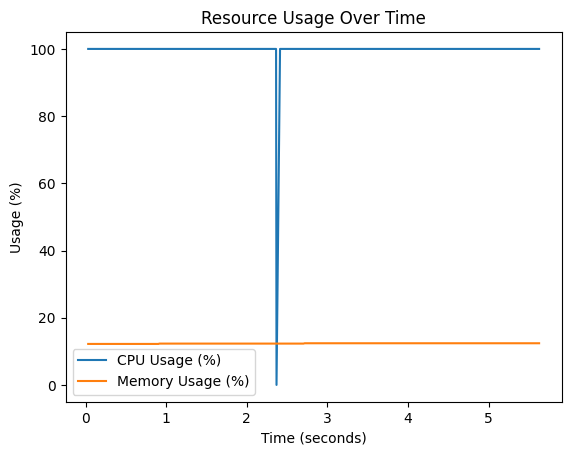

In [ ]:
import resource
from time import perf_counter
import matplotlib.pyplot as plt
import psutil

# Function to print resource usage
def print_resource_usage():
    print("Resource usage:")
    print(resource.getrusage(resource.RUSAGE_SELF))
    print("CPU usage:", psutil.cpu_percent(), "%")
    print("Memory usage:", psutil.virtual_memory().percent, "%")
    print("")

# Initialize lists to store resource usage data
cpu_usage = []
memory_usage = []
timestamps = []

# Get resource usage before encryption
print_resource_usage()

# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]

# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)

# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20

# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

# define the number of epochs for both plain and encrypted training
EPOCHS = 5

# Start monitoring resource usage
start_time = perf_counter()

# Encrypt the test set
for x in x_test:
    t_start = perf_counter()
    enc_x_test = ts.ckks_vector(ctx_eval, x.tolist())
    t_end = perf_counter()

    # Calculate elapsed time
    elapsed_time_milliseconds = (t_end - t_start) * 1000

    # Append resource usage data
    cpu_usage.append(psutil.cpu_percent())
    memory_usage.append(psutil.virtual_memory().percent)
    timestamps.append(perf_counter() - start_time)

    # Print resource usage after each encryption
    print("After encrypting test set:")
    print_resource_usage()

# Plot CPU and memory usage over time
plt.plot(timestamps, cpu_usage, label='CPU Usage (%)')
plt.plot(timestamps, memory_usage, label='Memory Usage (%)')
plt.xlabel('Time (seconds)')
plt.ylabel('Usage (%)')
plt.title('Resource Usage Over Time')
plt.legend()
plt.show()


Resource usage:
resource.struct_rusage(ru_utime=30.231799, ru_stime=3.39358, ru_maxrss=806720, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=137741, ru_majflt=2708, ru_nswap=0, ru_inblock=573024, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=112364, ru_nivcsw=29290)
CPU usage: 40.5 %
Memory usage: 12.6 %

After epoch 1:
Resource usage:
resource.struct_rusage(ru_utime=31.846843, ru_stime=3.410494, ru_maxrss=806720, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=137742, ru_majflt=2708, ru_nswap=0, ru_inblock=573024, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=112638, ru_nivcsw=30012)
CPU usage: 0.0 %
Memory usage: 12.6 %

After epoch 2:
Resource usage:
resource.struct_rusage(ru_utime=33.328363, ru_stime=3.42972, ru_maxrss=806720, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=137742, ru_majflt=2708, ru_nswap=0, ru_inblock=573024, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=112939, ru_nivcsw=30886)
CPU usage: 0.0 %
Memory usage: 1

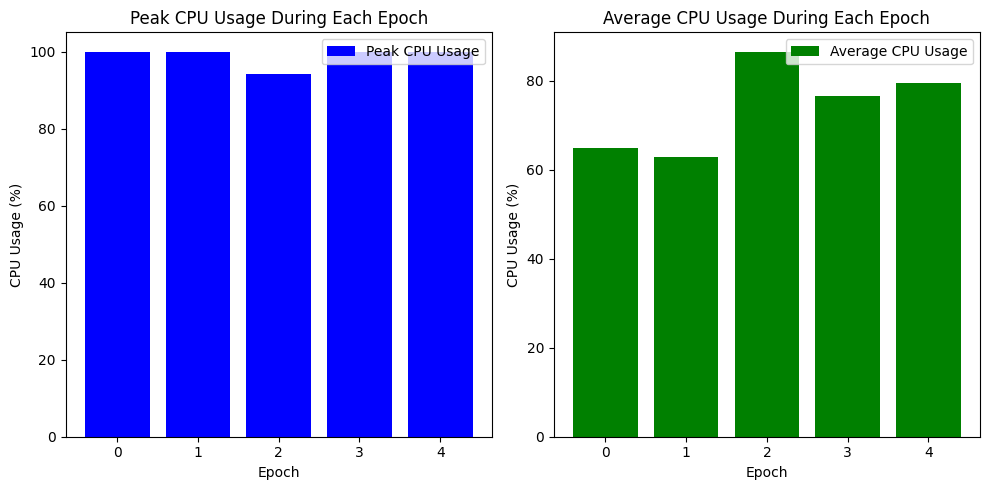

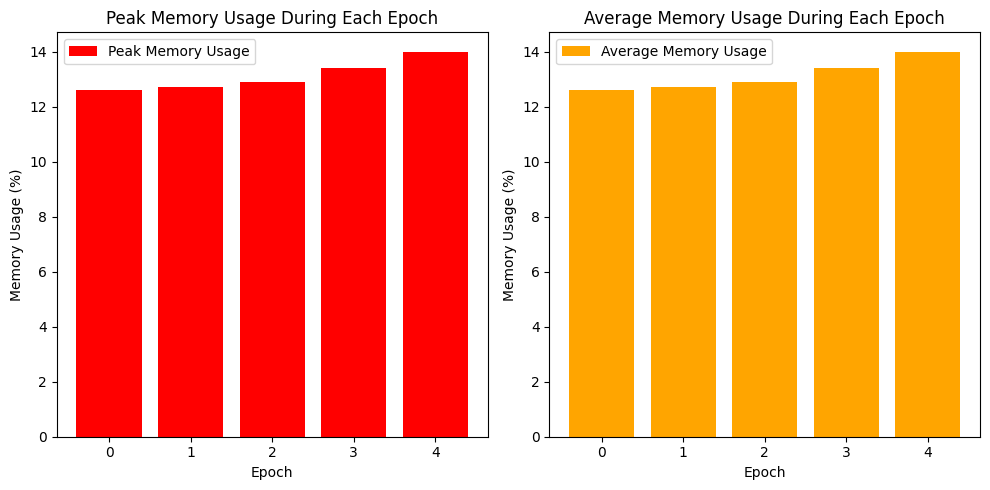

In [ ]:
import resource
from time import perf_counter
import matplotlib.pyplot as plt
import psutil

# Function to print resource usage
def print_resource_usage():
    print("Resource usage:")
    print(resource.getrusage(resource.RUSAGE_SELF))
    print("CPU usage:", psutil.cpu_percent(), "%")
    print("Memory usage:", psutil.virtual_memory().percent, "%")
    print("")

# Initialize lists to store resource usage data
cpu_peak_usage = []
cpu_average_usage = []
memory_peak_usage = []
memory_average_usage = []
epoch_numbers = []

# Get resource usage before encryption
print_resource_usage()

# parameters
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]

# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)

# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20

# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

# define the number of epochs for both plain and encrypted training
EPOCHS = 5

# Encrypt the test set
for epoch in range(EPOCHS):
    t_start = perf_counter()
    enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
    t_end = perf_counter()

    # Calculate elapsed time
    elapsed_time_milliseconds = (t_end - t_start) * 1000

    # Append resource usage data
    cpu_peak_usage.append(psutil.cpu_percent())
    cpu_average_usage.append(psutil.cpu_percent(interval=1))
    memory_peak_usage.append(psutil.virtual_memory().percent)
    memory_average_usage.append(psutil.virtual_memory().percent)
    epoch_numbers.append(epoch)

    # Print resource usage after each epoch
    print(f"After epoch {epoch + 1}:")
    print_resource_usage()


In [ ]:
#Training using batching

import torch
import torch.nn as nn
import torch.optim as optim
import tenseal as ts
from time import perf_counter
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

# Define a simple logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.lr = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out
print_resource_usage()
# Initialize model, optimizer, and loss function
input_size = featuresTrain.size(1)
output_size = 1  #binary classification
model = LogisticRegression(input_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=1.2)
criterion = torch.nn.BCELoss()

# Batch size and DataLoader
batch_size = 64
train_dataset = TensorDataset(featuresTrain, targetsTrain)
test_dataset = TensorDataset(featuresTest, targetsTest)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training function with batching
def train(model, optimizer, criterion, train_loader, num_epochs=5):
    for epoch in range(num_epochs):
        for i, (features, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Print loss occasionally
            if (i+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():}')

# Testing function with accuracy calculation
def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)
            predicted = (outputs >= 0.5).float()  # binary classification
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Train the model with batching
train(model, optimizer, criterion, train_loader)
print("Resource snap after train: ")
print_resource_usage()

# Test the model and calculate accuracy
test(model, test_loader)

print("After testing")
print_resource_usage()


Resource usage:
resource.struct_rusage(ru_utime=12.578998, ru_stime=1.769171, ru_maxrss=627240, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=103041, ru_majflt=2572, ru_nswap=0, ru_inblock=516648, ru_oublock=16, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=63341, ru_nivcsw=14575)
CPU usage: 88.8 %
Memory usage: 11.1 %

Epoch [1/5], Step [10/13], Loss: 0.5922771692276001
Epoch [2/5], Step [10/13], Loss: 0.6815765500068665
Epoch [3/5], Step [10/13], Loss: 0.4984894394874573
Epoch [4/5], Step [10/13], Loss: 0.6086075305938721
Epoch [5/5], Step [10/13], Loss: 0.5355702638626099
Resource snap after train: 
Resource usage:
resource.struct_rusage(ru_utime=15.830527, ru_stime=2.06862, ru_maxrss=759068, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=126274, ru_majflt=2702, ru_nswap=0, ru_inblock=571792, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=65659, ru_nivcsw=16389)
CPU usage: 99.1 %
Memory usage: 12.1 %

Test Accuracy: 63.47%
After testing
Resource usage:
resource.

In [ ]:
  class LR(torch.nn.Module):

      def __init__(self, n_features):
          super(LR, self).__init__()
          self.lr = torch.nn.Linear(n_features, 1)

      def forward(self, x):
          out = torch.sigmoid(self.lr(x))
          return out
  n_features = x_train.shape[1]
  model = LR(n_features)
  # use gradient descent with a learning_rate=1
  optim = torch.optim.SGD(model.parameters(), lr=1)
  # use Binary Cross Entropy Loss
  criterion = torch.nn.BCELoss()


  # parameters
  poly_mod_degree = 4096
  coeff_mod_bit_sizes = [40, 20, 40]
  # create TenSEALContext
  ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
  # scale of ciphertext to use
  ctx_eval.global_scale = 2 ** 20
  # this key is needed for doing dot-product operations
  ctx_eval.generate_galois_keys()

  # define the number of epochs for both plain and encrypted training
  EPOCHS = 5

  from time import perf_counter

  t_start = perf_counter()
  enc_x_test = [ts.ckks_vector(ctx_eval, x.tolist()) for x in x_test]
  t_end = perf_counter()

  # Calculate the elapsed time in milliseconds
  elapsed_time_milliseconds = (t_end - t_start) * 1000

  print(f"Encryption of the test-set took {elapsed_time_milliseconds} ms")

  print("before training:")
  print_resource_usage()

  def train(model, optim, criterion, x, y, epochs=EPOCHS):
      for e in range(1, epochs + 1):
          optim.zero_grad()
          out = model(x)
          loss = criterion(out, y)
          loss.backward()
          optim.step()
          print(f"Loss at epoch {e}: {loss.data}")
      return model

  model = train(model, optim, criterion, x_train, y_train)
  def accuracy(model, x, y):
      out = model(x)
      correct = torch.abs(y - out) < 0.5
      return correct.float().mean()
  print("after training")
  print_resource_usage()
  plain_accuracy = accuracy(model, x_test, y_test)
  print(f"Accuracy on plain test_set: {plain_accuracy}")



Encryption of the test-set took 1896.4137720004146 ms
before training:
Resource usage:
resource.struct_rusage(ru_utime=1814.703594, ru_stime=16.474983, ru_maxrss=3604504, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=836968, ru_majflt=2721, ru_nswap=0, ru_inblock=575080, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=616404, ru_nivcsw=355726)
CPU usage: 12.7 %
Memory usage: 34.2 %

Loss at epoch 1: 0.7162427306175232
Loss at epoch 2: 0.6442546248435974
Loss at epoch 3: 0.6167673468589783
Loss at epoch 4: 0.6040461659431458
Loss at epoch 5: 0.5971726775169373
after training
Resource usage:
resource.struct_rusage(ru_utime=1814.725332, ru_stime=16.47599, ru_maxrss=3604504, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=836969, ru_majflt=2721, ru_nswap=0, ru_inblock=575080, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=616437, ru_nivcsw=355752)
CPU usage: 100.0 %
Memory usage: 34.2 %

Accuracy on plain test_set: 0.667664647102356


Batch 1:
Resource usage:
resource.struct_rusage(ru_utime=3057.962106, ru_stime=22.028829, ru_maxrss=3609532, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=838259, ru_majflt=2721, ru_nswap=0, ru_inblock=575080, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=912998, ru_nivcsw=571902)
CPU usage: 0.0 %
Memory usage: 32.7 %

Encryption of batch 1 took 20 seconds

Batch 2:
Resource usage:
resource.struct_rusage(ru_utime=3068.001722, ru_stime=22.105232, ru_maxrss=3609532, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=838259, ru_majflt=2721, ru_nswap=0, ru_inblock=575080, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=915051, ru_nivcsw=576052)
CPU usage: 0.0 %
Memory usage: 34.0 %

Encryption of batch 2 took 15 seconds

Distribution on plain data:


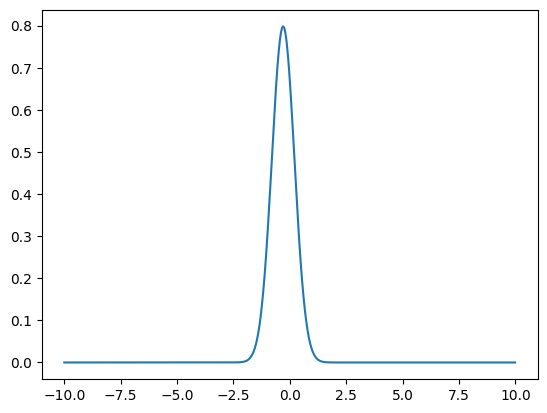

Distribution on encrypted data:


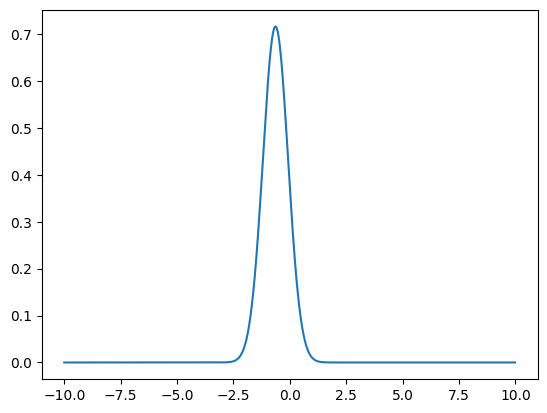

Accuracy at epoch #0 is 0.5958083868026733
before testing: 
Resource usage:
resource.struct_rusage(ru_utime=3121.888446, ru_stime=22.387738, ru_maxrss=3610316, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=838389, ru_majflt=2721, ru_nswap=0, ru_inblock=575080, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=928334, ru_nivcsw=586238)
CPU usage: 65.2 %
Memory usage: 34.1 %

after testing at epoch #1: 
Resource usage:
resource.struct_rusage(ru_utime=3230.879534, ru_stime=22.741037, ru_maxrss=3610316, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=838397, ru_majflt=2721, ru_nswap=0, ru_inblock=575080, ru_oublock=24, ru_msgsnd=0, ru_msgrcv=0, ru_nsignals=0, ru_nvcsw=947773, ru_nivcsw=605135)
CPU usage: 65.4 %
Memory usage: 31.0 %

Accuracy at epoch #1 is 0.6497005820274353
after testing at epoch #2: 
Resource usage:
resource.struct_rusage(ru_utime=3337.824979, ru_stime=23.037993, ru_maxrss=3610316, ru_ixrss=0, ru_idrss=0, ru_isrss=0, ru_minflt=838397, ru_majflt=2721, ru_nswa

In [ ]:
import math

class EncryptedLR:

    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()
        # we accumulate gradients and counts the number of iterations
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        enc_out = EncryptedLR.sigmoid(enc_out)
        return enc_out

    def backward(self, enc_x, enc_out, enc_y):
        out_minus_y = (enc_out - enc_y)
        self._delta_w += enc_x * out_minus_y
        self._delta_b += out_minus_y
        self._count += 1

    def update_parameters(self):
        if self._count == 0:
            raise RuntimeError("You should at least run one forward iteration")
        # update weights
        # We use a small regularization term to keep the output
        # of the linear layer in the range of the sigmoid approximation
        self.weight -= self._delta_w * (1 / self._count) + self.weight * 0.05
        self.bias -= self._delta_b * (1 / self._count)
        # reset gradient accumulators and iterations count
        self._delta_w = 0
        self._delta_b = 0
        self._count = 0

    @staticmethod
    def sigmoid(enc_x):
        return enc_x.polyval([0.5, 0.197, 0, -0.004])

    def plain_accuracy(self, x_test, y_test):
        # evaluate accuracy of the model on
        # the plain (x_test, y_test) dataset
        w = torch.tensor(self.weight)
        b = torch.tensor(self.bias)
        out = torch.sigmoid(x_test.matmul(w) + b).reshape(-1, 1)
        correct = torch.abs(y_test - out) < 0.5
        return correct.float().mean()

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)



# parameters
poly_mod_degree = 8192
coeff_mod_bit_sizes = [40, 21, 21, 21, 21, 21, 21, 40]
# create TenSEALContext
ctx_training = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx_training.global_scale = 2 ** 21
ctx_training.generate_galois_keys()

# Initialize lists to store resource usage data for each epoch/batch
cpu_usages = []
memory_usages = []
enc_x_train = []
enc_y_train = []
# Define the batch size
batch_size = 500

# Calculate the total number of batches
num_batches = math.ceil(len(x_train) / batch_size)

# Encryption of the training set with batching
for i in range(num_batches):
    t_start = time()  # Record start time for each batch

    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(x_train))  # Adjust end index for the last batch

    # Extract a batch of data
    batch_x = x_train[start_idx:end_idx]
    batch_y = y_train[start_idx:end_idx]

    # Encrypt the batch
    enc_x_batch = [ts.ckks_vector(ctx_training, x.tolist()) for x in batch_x]
    enc_y_batch = [ts.ckks_vector(ctx_training, y.tolist()) for y in batch_y]

    # Append the batch to the encrypted training set
    enc_x_train.extend(enc_x_batch)
    enc_y_train.extend(enc_y_batch)

    t_end = time()  # Record end time for each batch

    # Append CPU and memory usage data for each batch
    cpu_usages.append(psutil.cpu_percent())
    memory_usages.append(psutil.virtual_memory().percent)

    print(f"Batch {i+1}:")
    print_resource_usage()
    print(f"Encryption of batch {i+1} took {int(t_end - t_start)} seconds\n")

normal_dist = lambda x, mean, var: np.exp(- np.square(x - mean) / (2 * var)) / np.sqrt(2 * np.pi * var)

def plot_normal_dist(mean, var, rmin=-10, rmax=10):
    x = np.arange(rmin, rmax, 0.01)
    y = normal_dist(x, mean, var)
    fig = plt.plot(x, y)

# plain distribution
lr = LR(n_features)
data = lr.lr(x_test)
mean, var = map(float, [data.mean(), data.std() ** 2])
plot_normal_dist(mean, var)
print("Distribution on plain data:")
plt.show()

# encrypted distribution
def encrypted_out_distribution(eelr, enc_x_test):
    w = eelr.weight
    b = eelr.bias
    data = []
    for enc_x in enc_x_test:
        enc_out = enc_x.dot(w) + b
        data.append(enc_out.decrypt())
    data = torch.tensor(data)
    mean, var = map(float, [data.mean(), data.std() ** 2])
    plot_normal_dist(mean, var)
    print("Distribution on encrypted data:")
    plt.show()

eelr = EncryptedLR(lr)
eelr.encrypt(ctx_training)
encrypted_out_distribution(eelr, enc_x_train)

eelr = EncryptedLR(LR(n_features))
accuracy = eelr.plain_accuracy(x_test, y_test)
print(f"Accuracy at epoch #0 is {accuracy}")

times = []
print("before testing: ")
print_resource_usage()
for epoch in range(EPOCHS):
    eelr.encrypt(ctx_training)

    t_start = time()
    for enc_x, enc_y in zip(enc_x_train, enc_y_train):
        enc_out = eelr.forward(enc_x)
        eelr.backward(enc_x, enc_out, enc_y)
    eelr.update_parameters()
    t_end = time()
    times.append(t_end - t_start)

    eelr.decrypt()
    accuracy = eelr.plain_accuracy(x_test, y_test)

    print(f"after testing at epoch #{epoch + 1}: ")
    print_resource_usage()
    print(f"Accuracy at epoch #{epoch + 1} is {accuracy}")
print("Last print: ")
print_resource_usage()
print(f"\nAverage time per epoch: {int(sum(times) / len(times))} seconds")
print(f"Final accuracy is {accuracy}")

diff_accuracy = plain_accuracy - accuracy
print(f"Difference between plain and encrypted accuracies: {diff_accuracy}")
if diff_accuracy < 0:
    print("Oh! We got a better accuracy when training on encrypted data! The noise was on our side...")


In [ ]:
#cut from train code
# Define the batch size
batch_size = 500  # You can adjust this based on your available memory

# Calculate the total number of batches
num_batches = math.ceil(len(x_train) / batch_size)

# Encryption of the training set with batching
t_start = time()
enc_x_train = []
enc_y_train = []
print("Before encrypting training set: ")
print_resource_usage()
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size

    # Extract a batch of data
    batch_x = x_train[start_idx:end_idx]
    batch_y = y_train[start_idx:end_idx]

    # Encrypt the batch
    enc_x_batch = [ts.ckks_vector(ctx_training, x.tolist()) for x in batch_x]
    enc_y_batch = [ts.ckks_vector(ctx_training, y.tolist()) for y in batch_y]

    # Append the batch to the encrypted training set
    enc_x_train.extend(enc_x_batch)
    enc_y_train.extend(enc_y_batch)

t_end = time()

print("After encrypting training set: ")
print_resource_usage()

print(f"Encryption of the training set took {int(t_end - t_start)} seconds")
